In [1]:
from datetime import datetime
import pandas as pd
df = pd.read_csv('daylio_export.csv')


In [2]:
# Daylio uses this awful format: a column with the year,
# a column with the month name in English and the day number (e.g. June 10), and another with the time
# So this ugly procedure is necessary
# moreover, this is also affected by locale
import locale
locale.setlocale(locale.LC_ALL, 'de_DE.UTF-8')
def to_date(r):
    
    datetime_object = datetime.strptime(r['date'].split()[0] + ' ' + r['date'].split()[1].zfill(2) + ' ' + str(r['year']) + ' ' + r['time'],
                                            '%d. %B %Y %H:%M')

    return datetime_object
df['new_date'] = df.apply(to_date, axis=1)
df = df.set_index('new_date')
df = df.drop(['year', 'date','weekday', 'time'], axis=1)

# use a number for the mood value, not the string
df['mood'] = df.apply(lambda x: ['Lausig','fugly','Ok','Gut','Super'].index(x['mood']),axis=1)
#df['mood'] = df.apply(lambda x: ['awful','fugly','meh','good','rad'].index(x['mood']),axis=1)

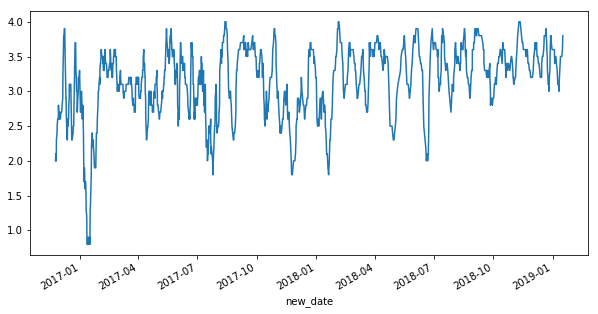

In [13]:

%matplotlib inline
df['mood_smooth'] = df['mood'].rolling(window=10).mean()
df['mood_smooth'].plot(figsize=(10, 5))

In [8]:
df['weekday'] = df.index.dayofweek
raw_dict = df.to_dict(orient='index')
# a dictionary with this key-value structure: 
# Timestamp('2016-07-07 22:03:00'): {'activities': 'work | friends',
#  'mood': 4,
#  'note': "something something"}, ...
from collections import Counter
import string
# dictionary mapping each punctuation codepoint to the space character one
punctuations_dict = dict.fromkeys(map(ord, string.punctuation), ord(' '))
words_general = Counter()
words_moods = [Counter() for i in range(5)]

for k,v in raw_dict.items():
    if type(v['note']) != str:
        # a record may not have a note
        print(f'ignored element for {k} {v}, had type {type(v["note"])}')
        continue
    # remove punctuations based on Unicode definition
    
    tokens =  v['note'].lower().translate(punctuations_dict).split()
    words_general.update(tokens)
    words_moods[v['mood']].update(tokens)

ignored element for 2018-10-31 23:03:00 {'mood': 4, 'activities': 'work | web idling ', 'note': nan, 'mood_smooth': 3.8, 'weekday': 2}, had type <class 'float'>
ignored element for 2018-09-06 21:45:00 {'mood': 4, 'activities': nan, 'note': nan, 'mood_smooth': 4.0, 'weekday': 3}, had type <class 'float'>
ignored element for 2017-12-23 23:10:00 {'mood': 4, 'activities': 'travel', 'note': nan, 'mood_smooth': 4.0, 'weekday': 5}, had type <class 'float'>
ignored element for 2017-08-01 21:45:00 {'mood': 4, 'activities': 'work', 'note': nan, 'mood_smooth': 2.8, 'weekday': 1}, had type <class 'float'>
ignored element for 2017-07-05 22:06:00 {'mood': 3, 'activities': 'work | web idling ', 'note': nan, 'mood_smooth': 3.0, 'weekday': 2}, had type <class 'float'>
ignored element for 2017-06-29 21:45:00 {'mood': 3, 'activities': 'web idling ', 'note': nan, 'mood_smooth': 3.4, 'weekday': 3}, had type <class 'float'>
ignored element for 2017-06-08 13:36:00 {'mood': 4, 'activities': 'work', 'note': na

In [9]:
print(len(words_general))
words_general.most_common(15)

1516


[('di', 261),
 ('e', 202),
 ('lavoro', 201),
 ('per', 174),
 ('a', 146),
 ('con', 137),
 ('un', 130),
 ('molto', 126),
 ('ma', 125),
 ('il', 115),
 ('al', 111),
 ('tutto', 103),
 ('bene', 102),
 ('ho', 102),
 ('in', 100)]

Now we have the word frequencies for each mood and in general.

For each word we can calculate the ratio between the occurrences in some mood and the total occurrences, to get a measure of the correlation between the word and the mood.

Words appearing a few times or just once, however, would have an excessively high polarity (that is, the correlation with a specific category); we need to not give too much weight to them. This is called smoothing and is a common step in Bayes models. There are various methods, based in general on the idea of adding an "hidden" number of occurrences for each token/category combination, an approach stemming from the assumption that by sampling we ignored some values that would have appeared with a bigger (or infinite) sample size.

I'll use the simplest smoothing, called Laplacian smoothing: just add a value for each token/category combination. This way, the polarity of tokens appearing few times will be spread between all the categories, while more common tokens will have a more defined polarity.

In [10]:
# for each token, add a fake sample to each mood pretending it appeared at least once for each
# if a mood actually had that token, it will just appear one more time
for w in words_general:
    for counter in words_moods:
        counter.update([w])
        

Now the polarity of the tokens for each category is calculated as the number of occurrences for that category divided by the total number of occurrences.

In [11]:
polarities = {}
for w in words_general:
    # words_general was not smoothed, so it still contains the actual count
    total = words_general[w] + len(words_moods)
    polarities[w] = [counter[w]/total for counter in words_moods]
import heapq
for m in range(5):
    print(f'tokens with highest polarity with class {m}:')
    higher = heapq.nlargest(10,polarities.items(), key=lambda x:x[1][m])
    print(list(map(lambda k: k[0], higher)))

tokens with highest polarity with class 0:
['morta', 'funerale', 'ballare', 'sarei', 'dovuto', 'venire', 'assoluta', 'riuscito', 'funzionare', 'annunciato']
tokens with highest polarity with class 1:
['hospice', 'zio', 'difficile', 'buttata', 'oziato', 'potrebbe', 'ultima', 'adatta', 'avevo', 'programma']
tokens with highest polarity with class 2:
['soliti', 'lavorare', 'casini', 'noia', 'voglia', 'stress', 'era', 'nessuno', 'raffreddato', 'poca']
tokens with highest polarity with class 3:
['ozio', 'più', 'ad', 'andando', 'faccio', 'fanno', 'passato', 'autobus', 'treno', 'box']
tokens with highest polarity with class 4:
['produttiva', 'cena', 'divertente', 'meetup', 'incontro', 'altri', 'bel', 'molto', 'eccitato', 'interessanti']
